# Data Processing

For every sensor we regularly receive data in the format
$$ \left( a_x, a_y, a_z, g_x, g_y, g_z \right) $$
where $a_x, a_y, a_z$ are acceleration in their respective directions and $g_x, g_y, g_z$ are yaw, pitch and roll respectively.

In addition, for the training data we have information about the current state of tapping, if the finger is currenly on the table or not. In practice the predictions can be used to get a estimation for the current state of tapping.

## Parse Data

For training there are two ways for us to receive the necessary data
1. from records stored on the SD card on the main boards and
2. live through a serial interface when the main board is connected to the PC.

### From Record

The file that is stored on the main board is of some format `data-*.txt`. Every line is either of the already discussed format or contains `v` or `^` to indicate that the finger starts or stops touching the table respectively.

We start with parsing the file into a numpy array with suitable structure.

In [1]:
import numpy as np

FILENAME = "data/dataset-3/data.txt"
SENSOR_COUNT = 6
SENSOR_VALUE_COUNT = 6

with open(FILENAME, 'r') as file:
    lines = file.read().strip().split('\n')

    # list of all readings
    all_readings = []
    # state of tapping
    pressing = False
    for line in lines:
        # check for change in state of tapping
        if "nt" in line: # TODO: change to "v"
            pressing = False
            continue
        elif "t" in line:
            pressing = True
            continue
            
        # one reading from all sensors (per line) flattened
        sensors = []
        for sensor_string in line.split(':'):
            # one sensor reading
            if sensor_string.count(';') != SENSOR_VALUE_COUNT-1:
                # set default values for non functional sensors
                sensors += [0, 0, 0, 0, 0, 0]
            else:
                sensors += [float(value) for value in sensor_string.split(';')]

        # add state of tapping to data entry
        sensors += [1 if pressing else 0]
        all_readings.append(sensors)

    data = np.array(all_readings)

### Through Serial

TODO

## Prepare Datasets

The datasets are formattings of the parsed data that can be passed to machine learning models as is.

To detect taps we try to strategies:
1. Detect press and release of taps separately. Easily extendable to holds.
2. Detect taps in one go.

The datasets will be saved using `joblib`.

In [2]:
from joblib import dump, load

# constants for press dataset
PRESS_BUFFER_SIZE = 3 # number of readings as input
PRESS_DATASET_FILENAME = "press_dataset.joblib"

# constats for release dataset
RELEASE_BUFFER_SIZE = 3
RELEASE_DATASET_FILENAME = "release_dataset.joblib"

FEATURE_NAMES = []

for reading in range(3):
    for sensor in range(6):
        for datum in ["acc_x", "acc_y", "acc_z","gyr_x", "gyr_y", "gyr_z"]:
            FEATURE_NAMES.append(f"[{reading-2}] {datum} ({sensor})")

### Press

This dataset will have `PRESS_BUFFER_SIZE` readings before and including the current reading in $X$ along with the tap state change (from not pressing to pressing) as output in $\mathbf{y}$.

In [3]:
PRESS_DATASET_SIZE = len(data)-(PRESS_BUFFER_SIZE-1)

# dataset declaration
press_dataset = (
    # X (input matrix)
    np.empty(shape = (
        PRESS_DATASET_SIZE,
        PRESS_BUFFER_SIZE * (SENSOR_COUNT * SENSOR_VALUE_COUNT)
    )),
    # y (output vector)
    np.empty(shape = PRESS_DATASET_SIZE)
)

# populate dataset with data
X = press_dataset[0]
y = press_dataset[1]
for index in np.arange(PRESS_DATASET_SIZE):
    for buffer_index in np.arange(PRESS_BUFFER_SIZE):
        size  = SENSOR_COUNT*SENSOR_VALUE_COUNT
        start = size*buffer_index
        end   = size*(buffer_index+1)
        X[index][start:end] = data[index+buffer_index][:size]
    # if change of tapping state in buffer (from not to tap)
    # set output to 1 otherwise 0
    y[index] = 1 if data[index+(PRESS_BUFFER_SIZE-1)][-1] - data[index+(PRESS_BUFFER_SIZE-2)][-1] == 1 else 0

# save dataset in PRPRESS_DATASET_FILENAME
dump(press_dataset, PRESS_DATASET_FILENAME)

['press_dataset.joblib']

### Release

This data set is like the press dataset but the output will only be one on a tap state change from pressing to not pressing (release).

In [5]:
RELEASE_DATASET_SIZE = len(data)-(RELEASE_BUFFER_SIZE-1)

# dataset declaration
release_dataset = (
    # X (input matrix)
    np.empty(shape = (
        RELEASE_DATASET_SIZE,
        RELEASE_BUFFER_SIZE * (SENSOR_COUNT * SENSOR_VALUE_COUNT)
    )),
    # y (output vector)
    np.empty(shape = RELEASE_DATASET_SIZE)
)

# populate dataset with data
X = release_dataset[0]
y = release_dataset[1]
for index in np.arange(RELEASE_DATASET_SIZE):
    for buffer_index in np.arange(RELEASE_BUFFER_SIZE):
        size  = SENSOR_COUNT*SENSOR_VALUE_COUNT
        start = size*buffer_index
        end   = size*(buffer_index+1)
        X[index][start:end] = data[index+buffer_index][:size]
    # if change of tapping state in buffer (from tap to not)
    # set output to 1 otherwise 0
    y[index] = 1 if data[index+(RELEASE_BUFFER_SIZE-1)][-1] - data[index+(RELEASE_BUFFER_SIZE-2)][-1] == -1 else 0

# save dataset in RELEASE_DATASET_FILENAME
dump(release_dataset, RELEASE_DATASET_FILENAME)

['release_dataset.joblib']

### Tap

TODO

# Machine Learning

## Dataset Preprocessing

### Dataset Splitting

To avoid overfitting in certain cases and generally improve validity the results the dataset will be split into a larger training dataset (67%) and a smaller testing dataset (33%). For now we will explicitly set `random_state` to improve reproducibility.

Additionally, to get a better idea of how practical the resulting model will be there will be two more datasets for scoring: one for the true positives rate, and one for the true negatives rate.

#### Press Dataset

In [4]:
from sklearn.model_selection import train_test_split
import numpy as np
from joblib import dump, load

# full dataset
X, y = load(PRESS_DATASET_FILENAME)

# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.33, random_state = 100
)

# extended matrix
m = np.hstack((X_test, y_test.reshape((len(y_test),1))))

# only positives dataset
X_positive = m[m[:,-1] == 1, :-1]
y_positive = m[m[:,-1] == 1, -1]

# only negatives dataset
X_negative = m[m[:,-1] == 0, :-1]
y_negative = m[m[:,-1] == 0, -1]

#### Release Dataset

In [6]:
from sklearn.model_selection import train_test_split
import numpy as np
from joblib import dump, load

# full dataset
X, y = load(RELEASE_DATASET_FILENAME)

# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.33, random_state = 42
)

# extended matrix
m = np.hstack((X_test, y_test.reshape((len(y_test),1))))

# only positives dataset
X_positive = m[m[:,-1] == 1, :-1]
y_positive = m[m[:,-1] == 1, -1]

# only negatives dataset
X_negative = m[m[:,-1] == 0, :-1]
y_negative = m[m[:,-1] == 0, -1]

## Helper

Some potentially helpful helper functions. Collecting them here hopefully also increases readability.

### GridSearch

For easy hyperparameter tuning we use grid search. Since grid search is fairly expensive we determine four other scores alongside the f1-score which is used for finding the optimum.

All results should be saved in a dictionary in a file called `results.joblib`. The dictionary will have one entry per model type, e.g. `"Perceptron"` or `"LogisticRegression"`. Every of these entries will be another dictionary containing a mapping between the used tuple `(param_grid, scoring)` (the string of it actually) and the resulting trained classifier.

To achieve this the following function should be called after every grid search. Additionally if there are already results for the current execution the grid search function should respect that.

In [6]:
from joblib import dump, load
from os.path import exists
from sklearn.model_selection import ParameterGrid

RESULTS_FILE_NAME = "results.joblib"

def load_grid_search(model_key, scoring):
    if exists(RESULTS_FILE_NAME):
        storage = load(RESULTS_FILE_NAME)
        key = scoring
        if model_key in storage and key in storage[model_key]:
            return storage[model_key][key]
            
    return dict()


def prefix_param_grid(prefix, param_grid):
    if isinstance(param_grid, list):
        new_param_grid = []
        for sub_grid in param_grid:
            new_param_grid.append(
                prefix_param_grid(prefix, sub_grid)
            )

        return new_param_grid
    elif isinstance(param_grid, dict):
        new_param_grid = dict()
        for key, value in param_grid.items():
            new_param_grid[prefix + key] = value
            
        return new_param_grid
    else:
        return param_grid


def strip_param_grid(param_grid, storage):
    new_param_grid = []
    for param in ParameterGrid(param_grid):
        if not str(param) in storage:
            new_param = dict()
            for key, value in param.items():
                new_param[key] = [value]
                
            new_param_grid.append(new_param)

    return new_param_grid


def update_grid_search(storage, clf, scoring, refit):
    for index, param in enumerate(clf.cv_results_["params"]):
        param = str(param)
        if not param in storage:
            new_scores = []
            for score in scoring:
                score_key = "mean_test_"+score
                if score_key in clf.cv_results_:
                    new_scores.append(clf.cv_results_[score_key][index])
                else:
                    new_scores.apppend(np.nan)

            storage[param] = new_scores

    if refit in scoring:
        refit_index = scoring.index(refit)
        if "best" in storage:
            current_best = str(storage["best"])
            current_score = storage[current_best][refit_index]
            
            new_best = str(clf.best_params_)
            new_score = storage[new_best][refit_index]
    
            if new_score > current_score:
                storage["best"] = clf.best_params_
        else:
            storage["best"] = clf.best_params_
    else:
        print("Something went wrong: refit score not in scoring.")
        


def train_best_grid_search(model, storage):
    try:
        param = storage["best"]
        scores = storage[str(param)]
        model.set_params(**param)
        model.fit(X_train, y_train)
        return scores
    except Exception as e:
        print("Could not determine best model:", e)
        return []


def save_grid_search(model_key, scoring, storage):
    if exists(RESULTS_FILE_NAME):
        database = load(RESULTS_FILE_NAME)
    else:
        database = dict()

    if not model_key in database:
        database[model_key] = dict()

    database[model_key][scoring] = storage

    dump(database, RESULTS_FILE_NAME)

Now the actual implementation of the grid search wrapper.

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
import warnings

SCORING = ("accuracy", "precision", "recall", "balanced_accuracy", "f1")
REFIT = "f1"

def run_grid_search(model, initial_param_grid):
    pipe = Pipeline(steps=[
        ("scaler", StandardScaler()), 
        ("model", model)
    ])

    model_key = str(pipe)
    
    storage = load_grid_search(model_key, SCORING)

    param_grid = strip_param_grid(
        prefix_param_grid("model__", initial_param_grid),
        storage
    )

    print(f"Processing {len(param_grid)} of {len(ParameterGrid(initial_param_grid))} fits.")
    
    clf = GridSearchCV(
        estimator = pipe,
        param_grid = param_grid,
        scoring = SCORING,
        n_jobs = -1,
        refit = REFIT,
        verbose = 1
    )

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        if len(param_grid) > 0:
            clf.fit(X_train, y_train)
            
            update_grid_search(storage, clf, SCORING, REFIT)
    
    best_clf = Pipeline(steps=[
        ("scaler", StandardScaler()), 
        ("model", model)
    ])
    scores = train_best_grid_search(best_clf, storage)

    print(storage["best"])
    save_grid_search(model_key, SCORING, storage)
    
    return scores, best_clf

#### GridSearch Summary

This function is intended to give a quick summary of some grid search result.

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, balanced_accuracy_score, f1_score

def summarize_grid_search(scores, clf):
    # print(f"{clf.get_params()}")
    
    print("--- Evaluation ---")
    for index, score in enumerate(SCORING):
        print(f"{score}: {scores[index]}")
        
    print("\n--- Test Set ---")
    print(f"accuracy: {accuracy_score(y_test, clf.predict(X_test))}")
    print(f"precision: {precision_score(y_test, clf.predict(X_test))}")
    print(f"recall: {recall_score(y_test, clf.predict(X_test))}")
    print(f"balanced_accuracy: {balanced_accuracy_score(y_test, clf.predict(X_test))}")
    print(f"f1: {f1_score(y_test, clf.predict(X_test))}")
    print(f"\nnegative set: {accuracy_score(y_negative, clf.predict(X_negative))}\n")
    

## Logistic Regression

https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


### Press Dataset

In [9]:
%%time
from sklearn.linear_model import LogisticRegression

param_grid = [
    {
        "solver": ["lbfgs"],
        "penalty": ["l2"],
        "C": 10.0 ** np.arange(-6, 3),
        "class_weight": [{1: weight} for weight in np.arange(1,20)] + ["balanced"]
    },
    {
        "solver": ["lbfgs"], 
        "penalty": [None], 
        "class_weight": [{1: weight} for weight in np.arange(1,20)] + ["balanced"]
    },
    {
        "solver": ["saga"],
        "penalty": ["l1", "l2", "elasticnet"],
        "C": 10.0 ** np.arange(-6, 3),
        "class_weight": [{1: weight} for weight in np.arange(1,20)] + ["balanced"]
    },
    {
        "solver": ["saga"],
        "penalty": [None],
        "class_weight": [{1: weight} for weight in np.arange(1,20)] + ["balanced"]
    },
]
    

scores, clf = run_grid_search(LogisticRegression(), param_grid)

summarize_grid_search(scores, clf)

Processing 0 of 760 fits.
{'model__C': 1, 'model__class_weight': {1: 3}, 'model__penalty': None, 'model__solver': 'lbfgs'}
--- Evaluation ---
accuracy: 0.9052966101694915
precision: 0.5608776193614945
recall: 0.7884108527131783
balanced_accuracy: 0.8543820422973539
f1: 0.6550564622209081

--- Test Set ---
accuracy: 0.9133333333333333
precision: 0.5781041388518025
recall: 0.8326923076923077
balanced_accuracy: 0.8780894952505123
f1: 0.682427107959023

negative set: 0.9234866828087167

CPU times: user 5.38 s, sys: 2.59 s, total: 7.97 s
Wall time: 4.98 s


### Release Dataset

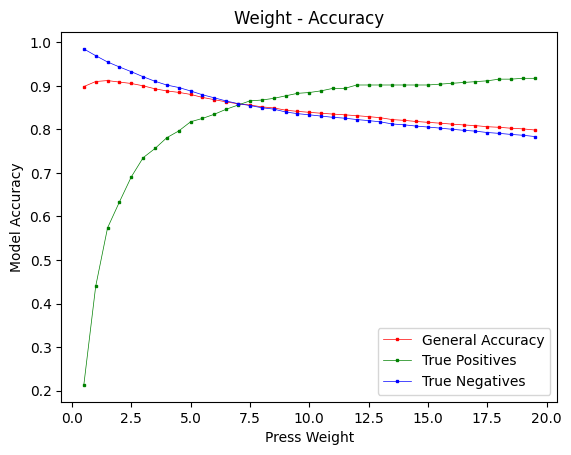

In [9]:
weight_range = np.arange(.5, 20., .5)
scores = lr_get_scores(weight_range)

# plot scores
plt.plot(weight_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(weight_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(weight_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("Weight - Accuracy")
plt.xlabel("Press Weight")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

## Decision Tree Learning

https://scikit-learn.org/stable/modules/tree.html#tree-classification

The goal for decision tree learning is to create a tree that at every node splits according to some threshold value for some feature chosen scored by the criterion. The algorithm creates further nodes for the tree as long as some condition is not fulfilled. We use the `scikit-learn` implementation.

### Press Dataset

In [10]:
%%time
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "splitter": ["best", "random"],
    "class_weight": [{1: weight} for weight in np.arange(1,20)]
}

score, clf = run_grid_search(DecisionTreeClassifier(), param_grid)

summarize_grid_search(score, clf)

Processing 0 of 114 fits.
{'model__class_weight': {1: 8}, 'model__criterion': 'entropy', 'model__splitter': 'best'}
--- Evaluation ---
accuracy: 0.9252118644067797
precision: 0.6717344369440102
recall: 0.6753186907838071
balanced_accuracy: 0.8163720910254815
f1: 0.6731879088801387

--- Test Set ---
accuracy: 0.9258064516129032
precision: 0.6582278481012658
recall: 0.7
balanced_accuracy: 0.8271186440677967
f1: 0.6784715750232991

negative set: 0.9542372881355933

CPU times: user 5.08 s, sys: 126 ms, total: 5.2 s
Wall time: 5.23 s


### Release Dataset

#### Gini Criterion

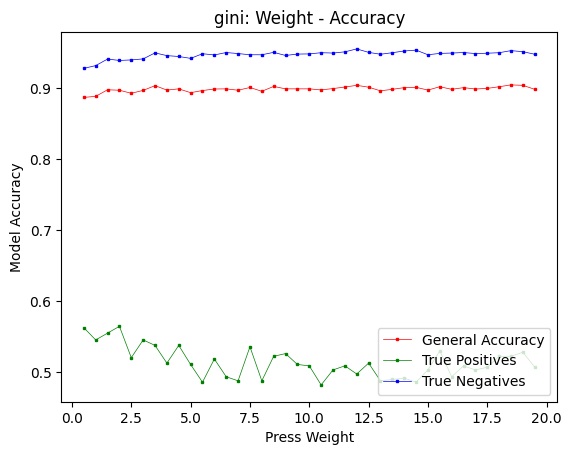

In [11]:
weight_range = np.arange(.5, 20., .5)
scores = dtl_get_scores(weight_range, "gini") # gini kernel

# plot scores
plt.plot(weight_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(weight_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(weight_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("gini: Weight - Accuracy")
plt.xlabel("Press Weight")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

#### Entropy Criterion

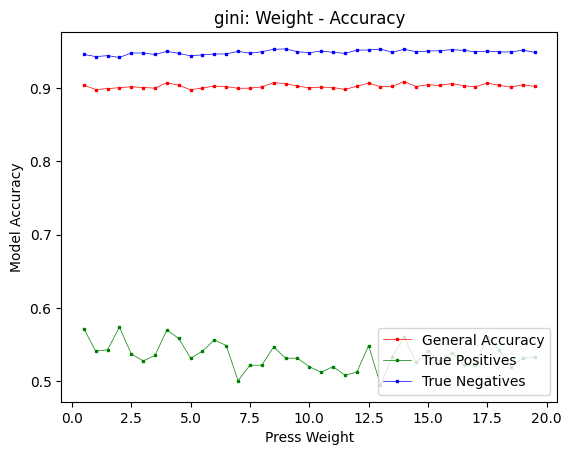

In [12]:
weight_range = np.arange(.5, 20., .5)
scores = dtl_get_scores(weight_range, "entropy") # entropy kernel

# plot scores
plt.plot(weight_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(weight_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(weight_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("gini: Weight - Accuracy")
plt.xlabel("Press Weight")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

#### Log_loss Criterion

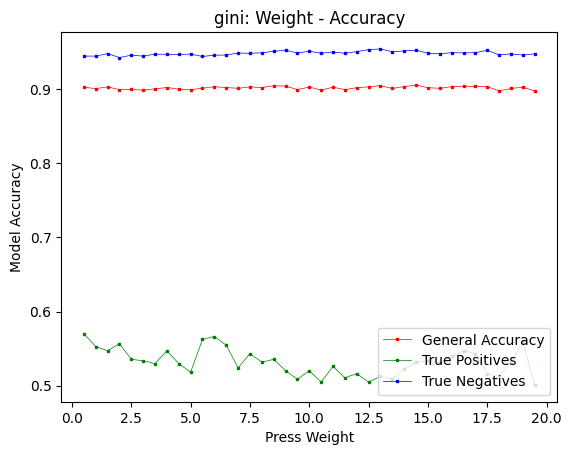

In [13]:
weight_range = np.arange(.5, 20., .5)
scores = dtl_get_scores(weight_range, "log_loss") # log_loss kernel

# plot scores
plt.plot(weight_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(weight_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(weight_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("gini: Weight - Accuracy")
plt.xlabel("Press Weight")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

## Random Forest

https://scikit-learn.org/stable/modules/ensemble.html#forest

A Random Forest consist of multiple Decision Trees trained with randomised input parts the final prediction of a Random Forest is the averaged prediction of the individual classifiers.

### Press Dataset

In [17]:
%%time
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    "n_estimators": [10, 100],
    "criterion": ["gini", "entropy", "log_loss"],
    "class_weight": [{1: weight} for weight in np.arange(1,20)]
}

score, clf = run_grid_search(RandomForestClassifier(), param_grid)

summarize_grid_search(score, clf)

Processing 0 of 114 fits.
{'model__class_weight': {1: 1}, 'model__criterion': 'log_loss', 'model__n_estimators': 100}
--- Evaluation ---
accuracy: 0.948093220338983
precision: 0.8229327398735725
recall: 0.6948062015503875
balanced_accuracy: 0.8377762736274462
f1: 0.7533789284233869

--- Test Set ---
accuracy: 0.9505376344086022
precision: 0.8231578947368421
recall: 0.7281191806331471
balanced_accuracy: 0.8538480658818544
f1: 0.7727272727272727

negative set: 0.9795769511305616

CPU times: user 2.71 s, sys: 15.2 ms, total: 2.72 s
Wall time: 2.72 s


### Release Dataest

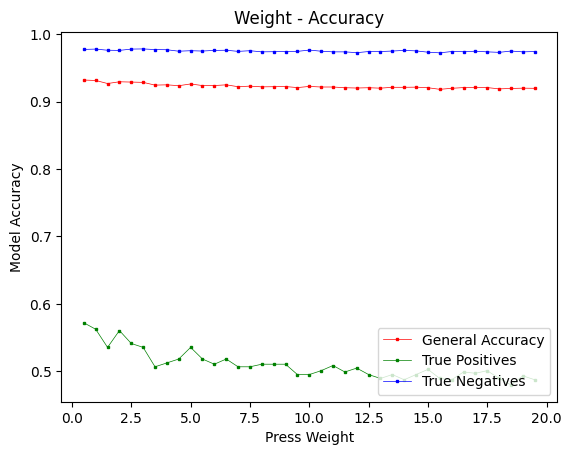

In [15]:
weight_range = np.arange(.5, 20., .5)
scores = rfc_get_scores(weight_range)

# plot scores
plt.plot(weight_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(weight_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(weight_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("Weight - Accuracy")
plt.xlabel("Press Weight")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

## Support Vector Machine (SVM)

https://scikit-learn.org/stable/modules/svm.html

A support vector machine tries to separate the training data with a hyperplane optimally using the features as coordinates. We will use the `scikit-learn` implementation. We also define some functions to more easily assess the models and improve readability.

### Press Dataset

In [26]:
%%time
from sklearn.svm import SVC

param_grid = [
    # Linear Kernel
    {
        "kernel": ["linear"],
        "C": 10.0 ** np.arange(-3, 2),
        "class_weight": [{1: weight} for weight in np.arange(1., 20.)]
    },
    # Poly Kernel
    {
        "kernel": ["poly"],
        "degree": [2, 3],
        "C": 10.0 ** np.arange(-3, 2),
        "coef0": [0, 0.1],
        "class_weight": [{1: weight} for weight in np.arange(1., 20., 4.)]
    },
    # RBF Kernel
    {
        "kernel": ["rbf"],
        "C": 10.0 ** np.arange(-3, 3),
        "class_weight": [{1: weight} for weight in np.arange(0.5, 5., 0.5)]
    },
    # Sigmoid Kernel
    {
        "kernel": ["sigmoid"],
        "C": 10.0 ** np.arange(-3, 2),
        "coef0": [0, 0.1],
        "class_weight": [{1: weight} for weight in np.arange(1, 20, 4)]
    }
]

score, clf = run_grid_search(SVC(), param_grid)

summarize_grid_search(score, clf)

Processing 0 of 299 fits.
{'model__C': 10.0, 'model__class_weight': {1: 2.0}, 'model__kernel': 'rbf'}
--- Evaluation ---
accuracy: 0.9433262711864406
precision: 0.7307114024611225
recall: 0.7986950904392764
balanced_accuracy: 0.8803329823766234
f1: 0.7629587411233489

--- Test Set ---
accuracy: 0.9481720430107526
precision: 0.7551724137931034
recall: 0.8156424581005587
balanced_accuracy: 0.8905588901249207
f1: 0.7842435094001791

negative set: 0.9654753221492828

CPU times: user 7.96 s, sys: 58.4 ms, total: 8.02 s
Wall time: 8 s


### Release Dataset

#### Linear Kernel

The linear was not considered at the beginning but since a standard scaler was introduced, it can now be considered.

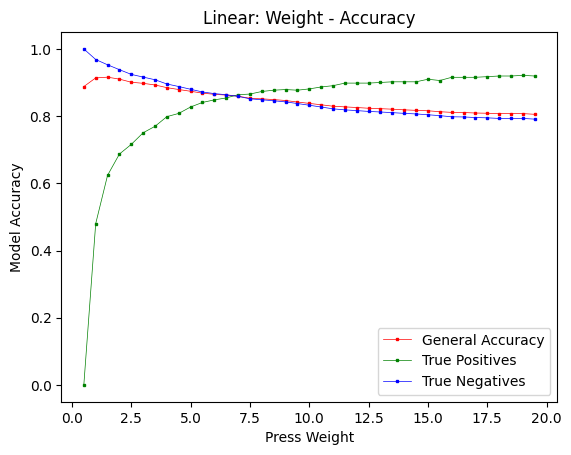

In [15]:
weight_range = np.arange(.5, 20., .5)
scores = svm_get_scores(weight_range, "linear") # linear kernel

# plot scores
plt.plot(weight_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(weight_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(weight_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("Linear: Weight - Accuracy")
plt.xlabel("Press Weight")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

#### Polynomial Kernel

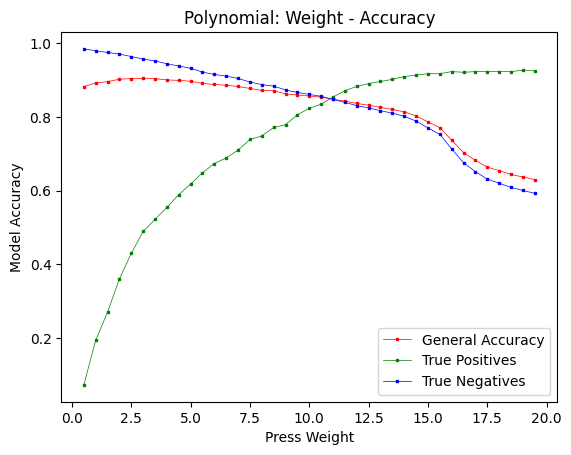

In [17]:
weight_range = np.arange(.5, 20., .5)
scores = svm_get_scores(weight_range, "poly") # polynomial kernel

# plot scores
plt.plot(weight_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(weight_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(weight_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("Polynomial: Weight - Accuracy")
plt.xlabel("Press Weight")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

#### Radial Basis Function (RBF) Kernel

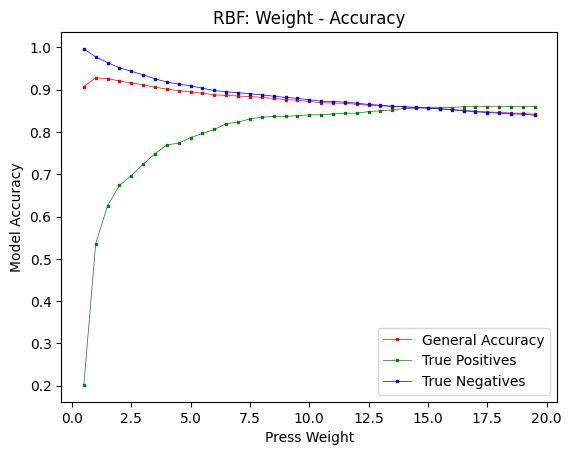

In [25]:
weight_range = np.arange(.5, 20., .5)
scores = svm_get_scores(weight_range, "rbf") # rbf kernel

# plot scores
plt.plot(weight_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(weight_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(weight_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("RBF: Weight - Accuracy")
plt.xlabel("Press Weight")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

#### Sigmoid Kernel

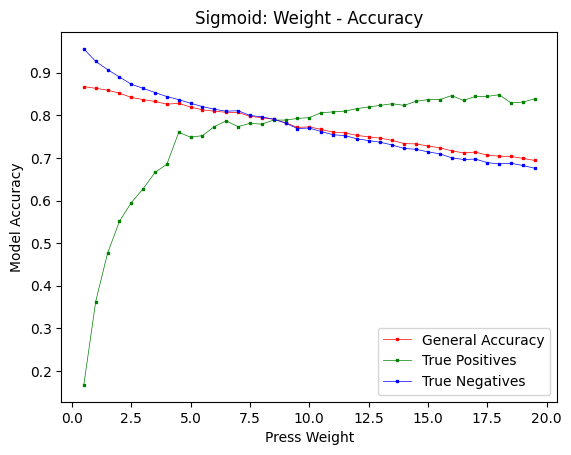

In [26]:
weight_range = np.arange(.5, 20., .5)
scores = svm_get_scores(weight_range, "sigmoid") # sigmoid kernel

# plot scores
plt.plot(weight_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(weight_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(weight_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("Sigmoid: Weight - Accuracy")
plt.xlabel("Press Weight")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

## $k$-Mean Classifier

https://scikit-learn.org/stable/modules/neighbors.html#classification

For some distance function get the $k$ nearest training dataset entries for the input and perform a majority vote to determine the corresponding output.

### Press Dataset

In [11]:
%%time
from sklearn.neighbors import KNeighborsClassifier

param_grid = [
    {
        "n_neighbors": np.arange(1, 10, 2),
        "weights": ["uniform", "distance"],
        "algorithm": ["ball_tree", "kd_tree"],
        "p": [1, 2]
    }
]

score, clf = run_grid_search(KNeighborsClassifier(), param_grid)

summarize_grid_search(score, clf)

Processing 0 of 40 fits.
{'model__algorithm': 'ball_tree', 'model__n_neighbors': 5, 'model__p': 1, 'model__weights': 'distance'}
--- Evaluation ---
accuracy: 0.9364406779661018
precision: 0.756006578159492
recall: 0.6549095607235141
balanced_accuracy: 0.8138216341641977
f1: 0.7017922090716534

--- Test Set ---
accuracy: 0.9391397849462365
precision: 0.7656903765690377
recall: 0.6815642458100558
balanced_accuracy: 0.827166756992069
f1: 0.7211822660098522

negative set: 0.9727692681740822

CPU times: user 43.2 s, sys: 23.6 ms, total: 43.3 s
Wall time: 43.3 s


### Release Dataset

#### Uniform Weighting

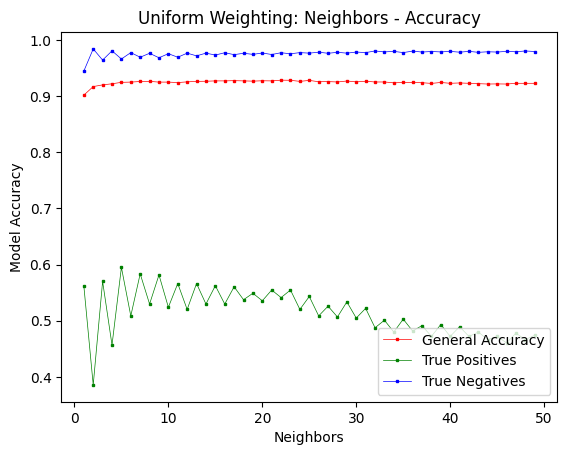

In [29]:
neighbor_range = np.arange(1, 50)
scores = knc_get_scores(neighbor_range, weights='uniform')

# plot scores
plt.plot(neighbor_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(neighbor_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(neighbor_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("Uniform Weighting: Neighbors - Accuracy")
plt.xlabel("Neighbors")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

#### Distance Weighting

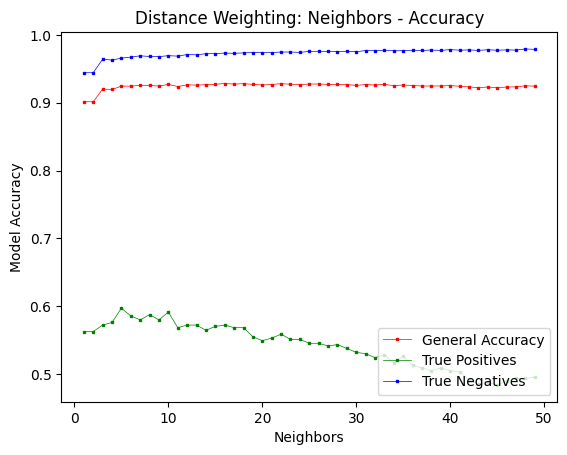

In [30]:
neighbor_range = np.arange(1, 50)
scores = knc_get_scores(neighbor_range, weights='distance')

# plot scores
plt.plot(neighbor_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(neighbor_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(neighbor_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("Distance Weighting: Neighbors - Accuracy")
plt.xlabel("Neighbors")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

## Perceptron Classifier

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html

Simple linear perceptron classifier.

### Press Dataset

In [23]:
%%time
from sklearn.linear_model import Perceptron

param_grid = {
    "penalty": ["l2", "l1", "elasticnet"],
    "alpha": 10.0 ** np.arange(-5, 1),
    "eta0": [0.1, 1, 10],
    "class_weight": [{1: weight} for weight in np.arange(1, 20)]
}

score, clf = run_grid_search(Perceptron(), param_grid)

summarize_grid_search(score, clf)

Processing 0 of 1026 fits.
{'model__alpha': 0.0001, 'model__class_weight': {1: 3}, 'model__eta0': 0.1, 'model__penalty': 'elasticnet'}
--- Evaluation ---
accuracy: 0.8742584745762711
precision: 0.4733386150770381
recall: 0.8515719207579672
balanced_accuracy: 0.8643754566567644
f1: 0.6078794993772039

--- Test Set ---
accuracy: 0.8868817204301075
precision: 0.5066666666666667
recall: 0.7783985102420856
balanced_accuracy: 0.8397219879194868
f1: 0.6138032305433186

negative set: 0.9010454655968879

CPU times: user 447 ms, sys: 293 ms, total: 740 ms
Wall time: 411 ms


### Release Dataset

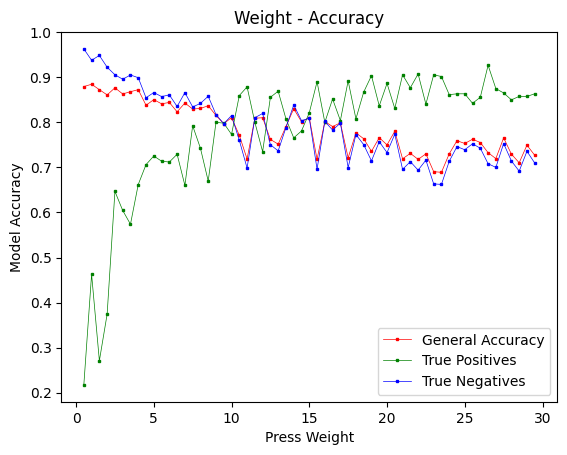

In [12]:
weight_range = np.arange(.5, 30., .5)
scores = perceptron_get_scores(weight_range)

# plot scores
plt.plot(weight_range, scores[0], "r-s",
         linewidth=0.5, markersize=2, label="General Accuracy")
plt.plot(weight_range, scores[1], "g-s",
         linewidth=0.5, markersize=2, label="True Positives")
plt.plot(weight_range, scores[2], "b-s",
         linewidth=0.5, markersize=2, label="True Negatives")

plt.title("Weight - Accuracy")
plt.xlabel("Press Weight")
plt.ylabel("Model Accuracy")
plt.legend(loc="lower right")

plt.show()

## Stochastic Gradient Descent

https://scikit-learn.org/stable/modules/sgd.html

A collection of loss functions optimised with SGD.

For hyperparameter optimization grid search will be performed over all reasonable hyperparameter settings.

In [26]:
%%time
from sklearn.linear_model import SGDClassifier

param_grid = [
    {
        "loss": ["hinge", "log_loss", "modified_huber", "squared_hinge", "perceptron"],
        "penalty": ["l2", "l1", "elasticnet"],
        "alpha": 10.0 ** np.arange(-5, 1),
        "learning_rate": ["optimal"],
        "class_weight": [{1: weight} for weight in np.arange(1., 20., 4.)]
    },
    {
        "loss": ["hinge", "log_loss", "modified_huber", "squared_hinge", "perceptron"],
        "penalty": ["l2", "l1", "elasticnet"],
        "alpha": 10.0 ** np.arange(-5, 1),
        "learning_rate": ["constant", "adaptive"],
        "eta0": 10.0 ** np.arange(-5, 1),
        "class_weight": [{1: weight} for weight in np.arange(1.5, 3., 0.5)]
    },
    {
        "loss": ["hinge", "log_loss", "modified_huber", "squared_hinge", "perceptron"],
        "penalty": ["l2", "l1", "elasticnet"],
        "alpha": 10.0 ** np.arange(-5, 1),
        "learning_rate": ["invscaling"],
        "eta0": 10.0 ** np.arange(-5, 1),
        "power_t": [-1, -0.5, 0.5, 1],
        "class_weight": [{1: weight} for weight in np.arange(1., 20., 4.)]
    }
]

score, clf = run_grid_search(SGDClassifier(), param_grid)

summarize_grid_search(score, clf)

Processing 0 of 14490 fits.
{'model__alpha': 0.0001, 'model__class_weight': {1: 2.5}, 'model__eta0': 0.1, 'model__learning_rate': 'adaptive', 'model__loss': 'hinge', 'model__penalty': 'l1'}
--- Evaluation ---
accuracy: 0.9169491525423729
precision: 0.6006172953628391
recall: 0.8172006890611542
balanced_accuracy: 0.8735010543690759
f1: 0.6921142415131352

--- Test Set ---
accuracy: 0.9131182795698924
precision: 0.5855855855855856
recall: 0.8472998137802608
balanced_accuracy: 0.8845057298903736
f1: 0.6925418569254186

negative set: 0.9217116460004863

CPU times: user 3.2 s, sys: 402 ms, total: 3.6 s
Wall time: 3.19 s


## Multi Layer Perceptron (Neural Network)

https://scikit-learn.org/stable/modules/neural_networks_supervised.html

In [27]:
%%time
from sklearn.neural_network import MLPClassifier

param_grid = [
    # LBFGS Solver
    {
        "hidden_layer_sizes": [(10,), (100,), (10, 10), (100, 10), (10, 3, 10)],
        "activation": ["logistic", "tanh", "relu"],
        "max_iter": [500],
        "solver": ["lbfgs"]
    },
    # SGD Solver
    {
        "hidden_layer_sizes": [(10,), (100,), (10, 10), (100, 10), (10, 3, 10)],
        "activation": ["logistic", "tanh", "relu"],
        "max_iter": [500],
        "solver": ["sgd"],
        "learning_rate": ["constant", "adaptive"],
        "learning_rate_init": 10.0 ** -np.arange(1,5),
        "momentum": [0.3, 0.8, 0.9]
    },
    # SGD Solver (invscaling)
    {
        "hidden_layer_sizes": [(10,), (100,), (10, 10), (100, 10), (10, 3, 10)],
        "activation": ["logistic", "tanh", "relu"],
        "max_iter": [500],
        "solver": ["sgd"],
        "learning_rate": ["invscaling"],
        "learning_rate_init": 10.0 ** -np.arange(1,5),
        "momentum": [0.3, 0.8, 0.9],
        "power_t": [-0.5, 0.5, 1]
    },
    # Adam Solver
    {
        "hidden_layer_sizes": [(10,), (100,), (10, 10), (100, 10), (10, 3, 10)],
        "activation": ["logistic", "tanh", "relu"],
        "max_iter": [500],
        "solver": ["adam"],
        "learning_rate_init": 10.0 ** -np.arange(1,5),
        "beta_1": [0.3, 0.9],
        "beta_2": [0.3, 0.999]
    }
]

score, clf = run_grid_search(MLPClassifier(), param_grid)

summarize_grid_search(score, clf)

Processing 0 of 1155 fits.
{'model__activation': 'logistic', 'model__beta_1': 0.3, 'model__beta_2': 0.3, 'model__hidden_layer_sizes': (10,), 'model__learning_rate_init': 0.001, 'model__max_iter': 500, 'model__solver': 'adam'}
--- Evaluation ---
accuracy: 0.9457627118644067
precision: 0.7662186470922241
recall: 0.7559991386735573
balanced_accuracy: 0.8631107997711759
f1: 0.7609333662736676

--- Test Set ---
accuracy: 0.9438709677419355
precision: 0.764367816091954
recall: 0.7430167597765364
balanced_accuracy: 0.8565557905374294
f1: 0.7535410764872521

negative set: 0.9700948212983224

CPU times: user 5.72 s, sys: 685 ms, total: 6.41 s
Wall time: 5.72 s


## Gradient Boosting Classifier

https://scikit-learn.org/stable/modules/ensemble.html#histogram-based-gradient-boosting

In [32]:
%%time
from sklearn.ensemble import HistGradientBoostingClassifier

param_grid = [
    {
        "learning_rate": np.arange(4, 5)/10,
        "l2_regularization": [0, 1, 2],
        "class_weight": [{1: 4}],
        "scoring": ["f1"]
    }
]

score, clf = run_grid_search(HistGradientBoostingClassifier(), param_grid)

summarize_grid_search(score, clf)

Processing 0 of 3 fits.
{'model__class_weight': {1: 4}, 'model__l2_regularization': 1, 'model__learning_rate': 0.4, 'model__scoring': 'f1'}
--- Evaluation ---
accuracy: 0.9525423728813559
precision: 0.7817717992889804
recall: 0.8107665805340224
balanced_accuracy: 0.8907934207663292
f1: 0.7959033618885301

--- Test Set ---
accuracy: 0.9550537634408602
precision: 0.7928571428571428
recall: 0.8268156424581006
balanced_accuracy: 0.8993061922477714
f1: 0.8094804010938924

negative set: 0.9717967420374423

CPU times: user 7.01 s, sys: 119 ms, total: 7.13 s
Wall time: 3.28 s


# Analysis

In this part we will take a closer look at our current best model and try to get some intuition on why it might work the way it does.

To do so we first have to determine which model is the best. We have three models that achieve similarly good f1-scores, namely:
- a support vector machine,
- a random forest,
- and a multi-layer-perceptron.

As the score of the support vector machine is a little bit better than the ones of the other two and as support vector machines have very fast prediction speeds, which might play a big role if we were to run the model on the microcontroller, we will choose it for now.

So our best model is:

In [38]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split
best_model = SVC(C = 10.0, kernel = "rbf", class_weight = {1: 2.0})
best_model.fit(X_train, y_train)
print("Accuracy: {}\nF1-Score: {}".format(
    best_model.score(X_test, y_test),
    f1_score(y_test, best_model.predict(X_test))
))

Accuracy: 0.9419354838709677
F1-Score: 0.761904761904762


## Permutation Importance

https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance

The first thing we do is try to find out which features of our input data are the most important. To do this we use permutation importance, meaning we fit a model for each feature while permutating the respective feature column, the decrease in model score will be the permutation importance.

In [28]:
%%time
from sklearn.inspection import permutation_importance

all_results = permutation_importance(
    clf, X_test, y_test,
    scoring = SCORING,
    n_repeats = 10,
    n_jobs = -1,
    random_state = 0
)

for metric in all_results:
    print(metric)
    result = all_results[metric]
    for i in result.importances_mean.argsort()[::-1]:
        if result.importances_mean[i] - 2 * result.importances_std[i] > 0:
            print(f"    {i:<4} {FEATURE_NAMES[i]:<20}" +
                  f"{result.importances_mean[i]:.3f}" +
                  f" +/- {result.importances_std[i]:.3f}")

accuracy
    73   [0] acc_y (0)       0.009 +/- 0.001
    7    [-2] acc_y (1)      0.008 +/- 0.002
    11   [-2] gyr_z (1)      0.008 +/- 0.002
    47   [-1] gyr_z (1)      0.008 +/- 0.002
    83   [0] gyr_z (1)       0.005 +/- 0.001
    44   [-1] acc_z (1)      0.004 +/- 0.001
    37   [-1] acc_y (0)      0.004 +/- 0.002
    91   [0] acc_y (3)       0.004 +/- 0.002
    98   [0] acc_z (4)       0.003 +/- 0.001
    21   [-2] gyr_x (3)      0.002 +/- 0.001
    27   [-2] gyr_x (4)      0.002 +/- 0.001
    80   [0] acc_z (1)       0.002 +/- 0.001
    72   [0] acc_x (0)       0.001 +/- 0.000
    42   [-1] acc_x (1)      0.001 +/- 0.000
    57   [-1] gyr_x (3)      0.001 +/- 0.001
    40   [-1] gyr_y (0)      0.001 +/- 0.000
    92   [0] acc_z (3)       0.001 +/- 0.001
    25   [-2] acc_y (4)      0.001 +/- 0.001
    41   [-1] gyr_z (0)      0.001 +/- 0.000
    76   [0] gyr_y (0)       0.001 +/- 0.000
    6    [-2] acc_x (1)      0.001 +/- 0.000
    99   [0] gyr_x (4)       0.001 +/- 0.000
p

## Partial Dependence Plots

https://scikit-learn.org/stable/modules/partial_dependence.html#partial-dependence

Next we will have a look at the partial dependence plots our model gives for our two most important features to get an intuition for how the model works.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   55.9s finished


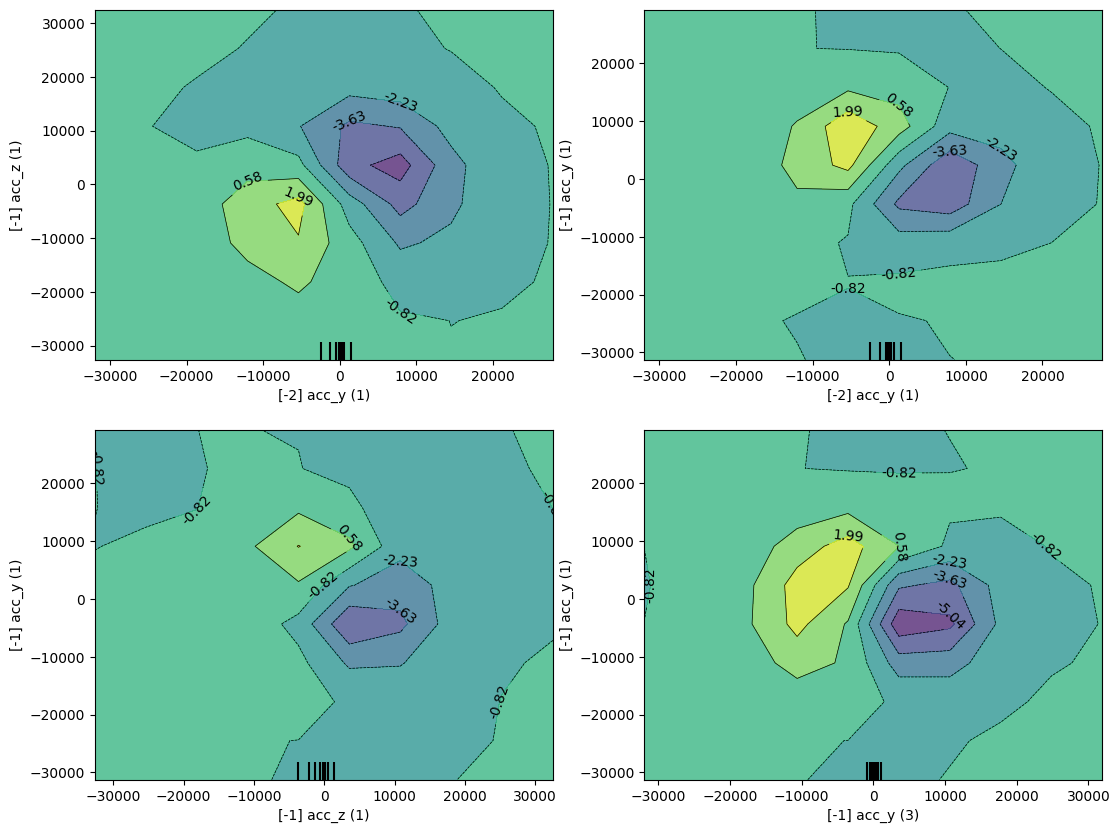

In [61]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [13, 10]

features = [(7, 44), (7, 43), (44, 43), (55, 43)]
display = PartialDependenceDisplay.from_estimator(
    best_model, X_test, features,
    feature_names = FEATURE_NAMES,
    grid_resolution = 10,
    percentiles = (0,1),
    n_cols = 2,
    n_jobs = -1,
    verbose = 4
)

Here is an overview of the impact of all features coming from the finger that is actually clicking. You can quite easily see how the features are used to predict an outcome:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  18 | elapsed:  2.0min remaining: 16.1min
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:  2.1min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done  12 out of  18 | elapsed:  2.1min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  3.0min finished


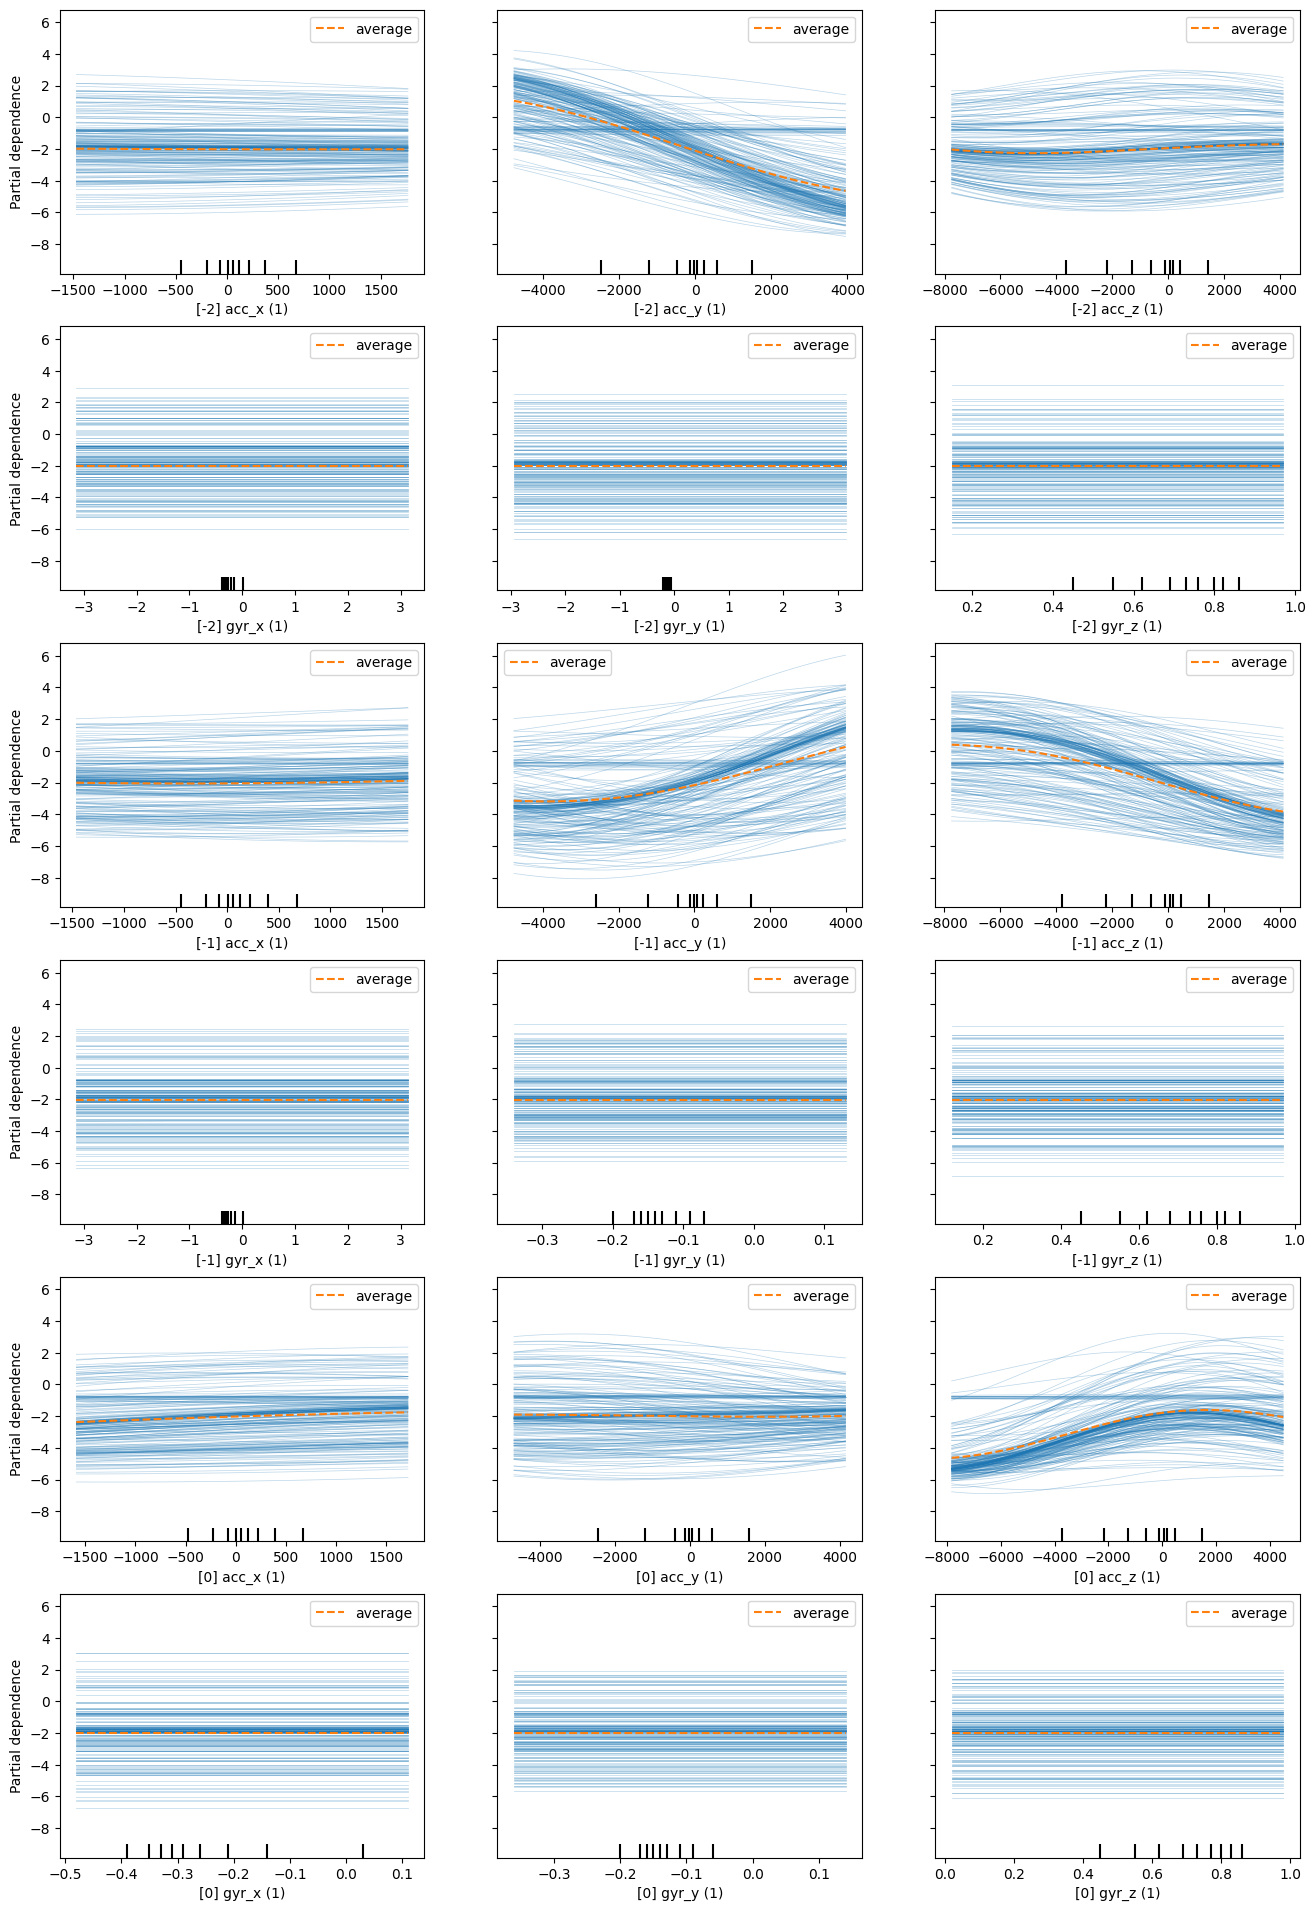

In [39]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 24] # 8.268 x 11.693

features = np.arange(6)+6
features = np.hstack([features, features+36, features+72])

display = PartialDependenceDisplay.from_estimator(
    best_model, X_test, features,
    feature_names = FEATURE_NAMES,
    grid_resolution = 100,
    percentiles = (0.01,0.99),
    n_cols = 3,
    n_jobs = -1,
    verbose = 4,
    kind="both",
    subsample = 200
)

To verify these results we will try to a model with just these for features:

In [84]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

selected_features = np.array([7, 43, 44, 80])

X_red = X[:,selected_features]

X_red_train, X_red_test, y_red_train, y_red_test = train_test_split(
    X_red, y, test_size = 0.33, random_state=42
)

sclf = make_pipeline(StandardScaler(), SVC(C=100, class_weight={1:2}))
sclf.fit(X_red_train, y_red_train)

(recall_score(y_red_test, sclf.predict(X_red_test)),
 precision_score(y_red_test, sclf.predict(X_red_test)),
 f1_score(y_red_test, sclf.predict(X_red_test)))

(0.7728119180633147, 0.5375647668393783, 0.6340718105423988)

## UMAP

https://umap-learn.readthedocs.io/en/latest/parameters.html

UMAP reduces the dimensionality to 2D to give some insights and intuition into how the data might be separable.

In [31]:
import umap

reducer = umap.UMAP()

embedding = reducer.fit_transform(X, y)
embedding.shape

(14090, 2)

This 2D embedding can be visualized as a plot:

Text(0.5, 1.0, 'UMAP projection')

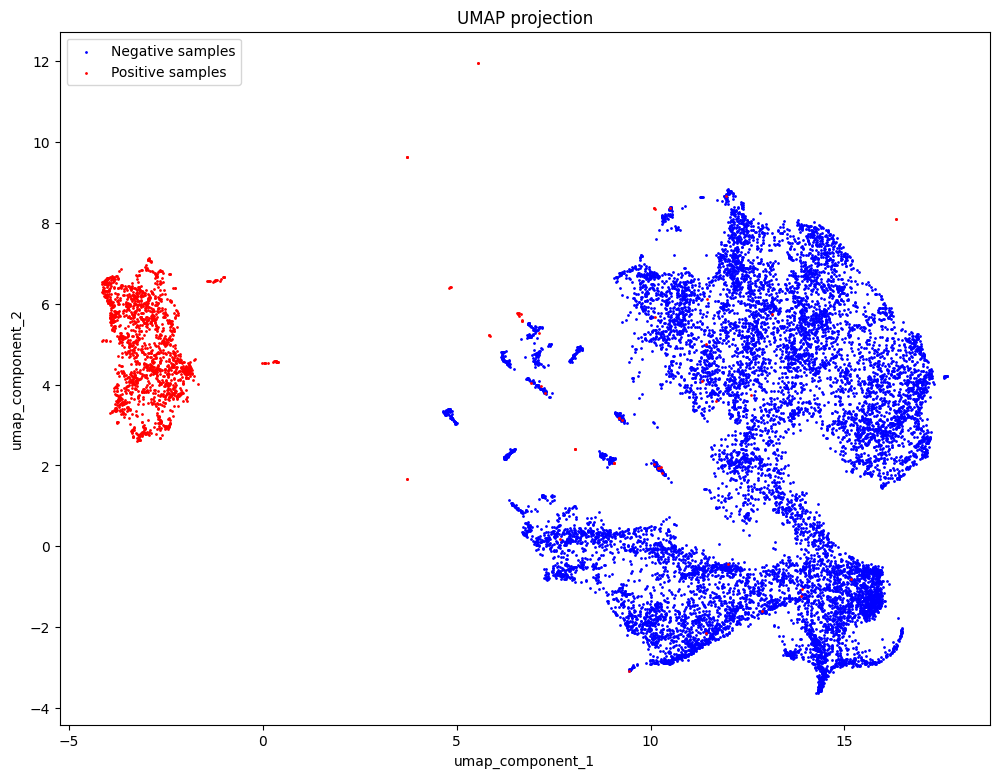

In [32]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 9]

plt.scatter(embedding[y==0,0], embedding[y==0,1], c="blue", s=1, label="Negative samples")
plt.scatter(embedding[y==1,0], embedding[y==1,1], c="red", s=1, label="Positive samples")

plt.legend(loc="upper left")
plt.xlabel(reducer.get_feature_names_out()[0])
plt.ylabel(reducer.get_feature_names_out()[1])
plt.title("UMAP projection")

In [36]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import Isomap, LocallyLinearEmbedding, SpectralEmbedding, TSNE

pca = TSNE(n_components=2, n_jobs=-1)

embedding = pca.fit_transform(X, y)
embedding.shape

(14090, 2)

Text(0.5, 1.0, 'Projection')

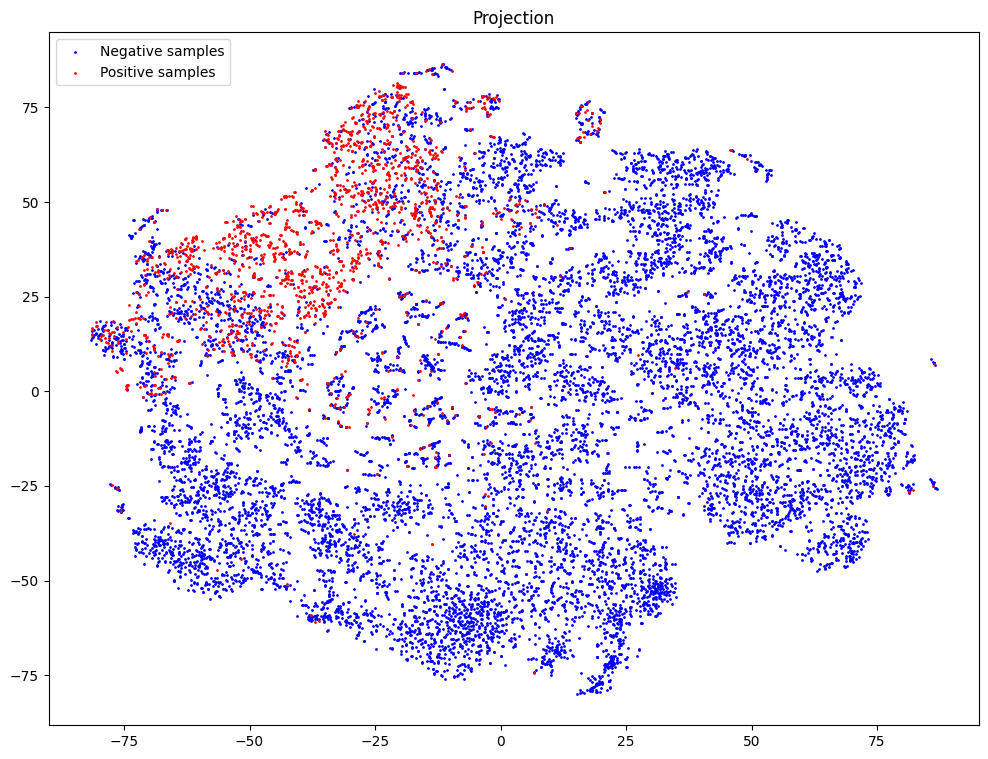

In [37]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 9]

plt.scatter(embedding[y==0,0], embedding[y==0,1], c="blue", s=1, label="Negative samples")
plt.scatter(embedding[y==1,0], embedding[y==1,1], c="red", s=1, label="Positive samples")

plt.legend(loc="upper left")
# plt.xlabel(reducer.get_feature_names_out()[0])
# plt.ylabel(reducer.get_feature_names_out()[1])
plt.title("Projection")